## Make the four panel $\sigma_{in}$, $\sigma_{out}$ plot

In [1]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DER, model_setup_DE
from data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import pandas as pd
import seaborn as sns

In [2]:
new_title_lookup = {'predictive': 'output injection', 'feature': 'input injection'}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoints = AggregateCheckpoints()

axes number 0
number of sims 10000
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this model 5
using this model 6


/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_7586/352418106.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}


using this model 7
using this model 8
using this model 9
number of sims 10000
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this model 5
using this model 6
using this model 7
using this model 8
using this model 9
number of sims 10000
NO WERE NOT VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this model 5
using this model 6
using this model 7
using this model 8
using this model 9
axes number 1
number of sims 10000
YES WERE VARYING SIGMA
linear_homoskedastic simulation data generated,                 with noise injected type: feature.
using this model 0
using this model 1
using this model 2
using this model 3
using this model 4
using this mo

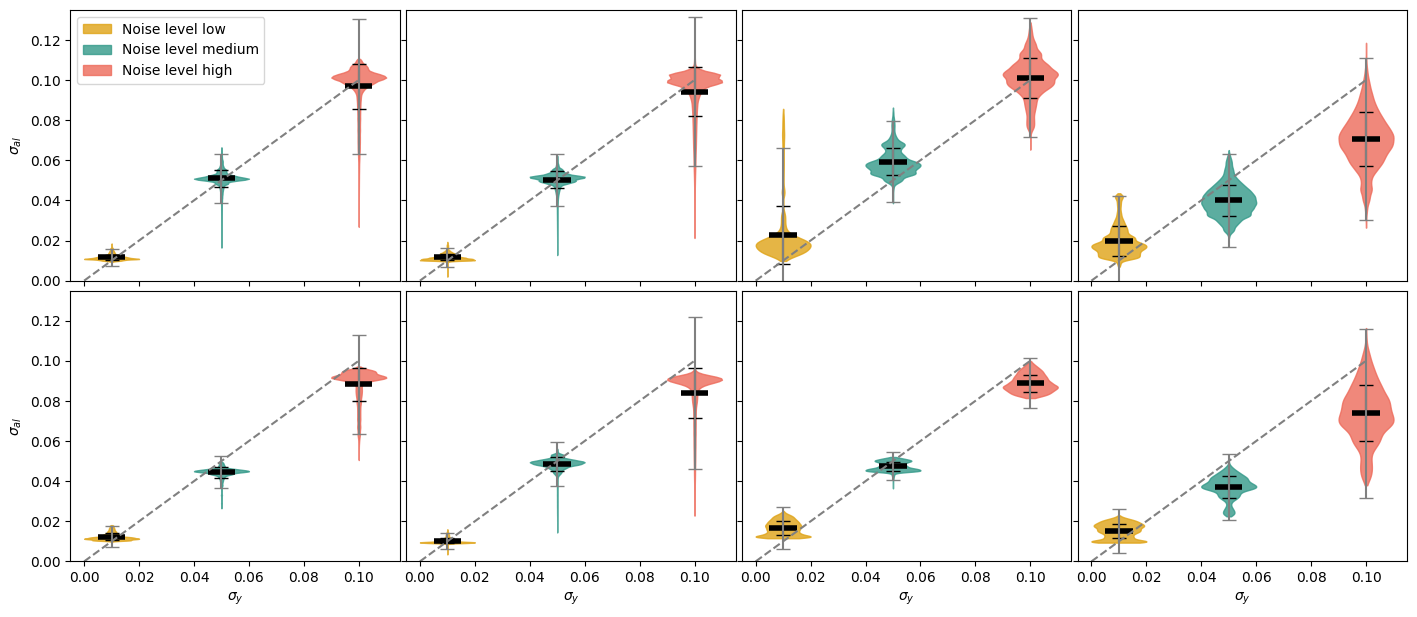

In [9]:
uniform = True
prescription = "linear_homoskedastic"
inject_type_list = ["predictive", "feature"]
data_dim_list = ["0D", "2D"]
model_type = ["DE", "DER"]
noise_list = ["low", "medium", "high"]

'''
inject_type_list = ["predictive"]
data_dim_list = ["2D"]
model_type = ["DE"]
noise_list = ["low"]
'''


# these are the three colors for the three noise levels
color_list = ["#DFA316", "#339989", "#ED6A5A", "#292F36"]
size_df_linear = 10000 # 1000
size_df_image = 175000
epoch = 99
ensemble = True
n_models = 15

fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
#, wspace=0, hspace=0)  
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)#wspace=-0.5, hspace=-0.5)
axes = axes.flatten()
index = 0

sigma_y_lookup = {'low': 0.01, 'medium': 0.05, 'high': 0.10}
# Iterate over the combinations of the two lists
for m, model in enumerate(model_type):
    for j, dim in enumerate(data_dim_list):
        for i, inject_type in enumerate(inject_type_list):
        
        
            ax = axes[index]
            print('axes number', index)
            #ax.set_title(f'{new_title_lookup[inject_type]} - {dim} - {model}')

            all_u_al_data = []  # Collect all data for the violin plot
            all_noise_labels = []
            all_sigma_y_labels = []
            for n, noise in enumerate(noise_list):
                chk = 0
                
                # make the test set
                data = DataPreparation()
                
                if dim == "0D":
                    data.sample_params_from_prior(size_df_linear)
                    if inject_type == "feature":
                        data.simulate_data(
                            data.params,
                            noise,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                            vary_sigma=True,
                        )
                    else:
                        sigma = DataPreparation.get_sigma(
                            noise, inject_type=inject_type, data_dimension=dim)
                        data.simulate_data(
                            data.params,
                            sigma,
                            "linear_homoskedastic",
                            inject_type=inject_type,
                            seed=41,
                        )
                    df_array = data.get_dict()
                    df = {key: torch.tensor(value) if not isinstance(value, TensorDataset) else value for key, value in df_array.items()}
                    len_df = len(df["params"][:, 0].numpy())
                    len_x = np.shape(df["output"])[1]
                    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
                    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
                    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
                    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
                    inputs = np.array([xs_array, ms_array, bs_array]).T
                    model_inputs = inputs
                    model_outputs = ys_array
                elif dim == "2D":
                    sigma = DataPreparation.get_sigma(
                        noise, inject_type=inject_type, data_dimension=dim)
                    data.sample_params_from_prior(
                        size_df_image,
                        low=[0, 1, -1.5],
                        high=[0.01, 10, 1.5],
                        n_params=3,
                        seed=41)
                    model_inputs, model_outputs = data.simulate_data_2d(
                        size_df_image,
                        data.params,
                        image_size=32,
                        inject_type=inject_type,
                        sigma=sigma)
                if uniform:
                    model_inputs, model_outputs = DataPreparation.select_uniform(
                        model_inputs, model_outputs, dim, verbose=False, rs=40
                    )
                x_test = model_inputs
                y_test = model_outputs
                
                path = "../DeepUQResources/checkpoints/"
                if model == "DER":
                    setupmodel, lossFn = model_setup_DER(
                        model, DEVICE, n_hidden=64, data_type=dim)
                    COEFF = 0.01
                    file_name = (
                        str(path)
                        + f"{model}_{prescription}_{inject_type}_{dim}"
                        + f"_noise_{noise}_loss_DER_COEFF_{COEFF}_epoch_{epoch}"
                    )
                    if dim == "0D":
                        file_name += f"_sizedf_{size_df_linear}"
                    elif dim == "2D":
                        file_name += f"_sizedf_{size_df_image}"
                    file_name += ".pt"
                    try:
                        #print('loading this file', file_name)
                        chk = torch.load(file_name, map_location=DEVICE)
                    except FileNotFoundError:
                        #print("cannot find this model", file_name)
                        continue
                    setupmodel.load_state_dict(chk.get("model_state_dict"))
                    setupmodel.eval()

                    y_pred = setupmodel(torch.Tensor(x_test)).detach().numpy()
                    beta = y_pred[:, 3]
                    nu = y_pred[:, 1]
                    alpha = y_pred[:, 2]
                    u_al = np.sqrt(abs(beta * (1 + nu) / (alpha * nu)))

                    all_u_al_data.extend(u_al) # was just u_al
                    all_sigma_y_labels.extend([sigma_y_lookup[noise]] * len(u_al))

                    #if noise == "high" and inject_type == "predictive" and dim == "2D":
                    #    print('u_al', u_al)
                    #    STOP
                    
                elif model == "DE":
                    models_used = 0
                    loss = "bnll_loss"
                    setupmodel, lossFn = model_setup_DE(
                        loss, DEVICE, n_hidden=64, data_type=dim)
                    BETA = 0.5
                    u_al_list = []
                    for m in range(n_models):
                        if models_used > 9:
                            break
                        file_name = (
                            str(path) +
                            f"{model}_{prescription}_{inject_type}_{dim}"
                            f"_noise_{noise}_beta_{BETA}_nmodel_{m}_epoch_{epoch}"
                        )
                        if dim == "0D":
                            file_name += f"_sizedf_{size_df_linear}"
                        elif dim == "2D":
                            file_name += f"_sizedf_{size_df_image}"
                        file_name += ".pt"
                        try:
                            #print('loading this file', file_name)
                            chk = torch.load(file_name, map_location=DEVICE)
                        except FileNotFoundError:
                            # print("cannot find this model", file_name)
                            continue
                        setupmodel.load_state_dict(chk.get("model_state_dict"))
                        setupmodel.eval()
                        y_pred = setupmodel(torch.Tensor(x_test)).detach().numpy()
                        # for some reason if the model fails it predicts
                        # really large values for sigma
                        
                        if np.all(y_pred[:, 1] == y_pred[0, 1]) or np.mean(np.sqrt(y_pred[:, 1])) > 0.2:
                            # All values are the same
                            print("All values in y_pred[:,1] are the same or they are really high")
                            # then we need to skip this model
                            print('not using this model ', m)
                            continue
                        else:
                            '''
                            plt.clf()
                            plt.hist(np.sqrt(y_pred[:, 1]), bins=100)
                            plt.title(f'model m {m}')
                            plt.show()
                            '''
                            print('using this model', m)
                            models_used += 1
                            #print('using this model ', m)            
                        u_al = np.sqrt(y_pred[:, 1])
                        u_al_list.append(np.mean(u_al))
                        # collect the data after each ensemble member that has converged
                        all_u_al_data.extend(u_al) # was just u_al
                        all_sigma_y_labels.extend([sigma_y_lookup[noise]] * len(u_al))
                    '''
                    if noise == "low":
                        ax.annotate(f'nmodels = {models_used}', xy=(0.02,0.5), xycoords='axes fraction')
                    if noise == "medium":
                        ax.annotate(f'nmodels = {models_used}', xy=(0.02,0.4), xycoords='axes fraction')
                    if noise == "high":
                        ax.annotate(f'nmodels = {models_used}', xy=(0.02,0.3), xycoords='axes fraction')
                    '''
            
            '''
            plt.clf()
            plt.hist(u_al_list, bins=100)
            plt.title('u_al_list')
            plt.show()

            plt.clf()
            plt.hist(all_u_al_data, bins=100)
            plt.title('all_u_al_data')
            plt.show()
            '''
            
            # Create a DataFrame for the box plot
            df_boxplot = pd.DataFrame({
                'u_al': all_u_al_data,
                'sigma_y': all_sigma_y_labels
            })

            # Prepare the data for the box plot
            sigma_y_values = [0.01, 0.05, 0.1]
            data = [df_boxplot[df_boxplot['sigma_y'] == val]['u_al'] for val in sigma_y_values]
            # print('data', data)
            # print('df_boxplot', np.shape(df_boxplot), df_boxplot)

            


            '''
            # Plot the box plot with specific positions using Matplotlib's boxplot method
            bp = ax.boxplot(data, positions=sigma_y_values, widths=0.02, patch_artist=True, whis=1.5, showfliers=False)

            # Set colors for each box
            for patch, color in zip(bp['boxes'], color_list):
                patch.set_facecolor(color)

            # control the color of the median line
            # Set colors for median lines
            median_color = 'white'  # Change this to your desired color
            for median in bp['medians']:
                median.set_color(median_color)
                median.set_linewidth(2)
            '''
            # violinplot option
            try:
                vp = ax.violinplot(
                    data, positions=sigma_y_values, widths=0.02, showmeans=True, showextrema=False)#, alpha=0.7)
            except ValueError:
                continue
            
            # Set colors for each violin plot
            for body, color in zip(vp['bodies'], color_list):
                body.set_facecolor(color)
                body.set_edgecolor(color)
                body.set_alpha(0.8)  # Adjust the transparency if desired
            
            # Customize the appearance of the median line
            median_color = 'black'  # Change this to your desired color
            if 'cmeans' in vp:
                vp['cmeans'].set_color(median_color)
                vp['cmeans'].set_linewidth(4)
            means = [np.mean(df_boxplot[df_boxplot['sigma_y']==0.01]['u_al']),
                     np.mean(df_boxplot[df_boxplot['sigma_y']==0.05]['u_al']),
                     np.mean(df_boxplot[df_boxplot['sigma_y']==0.1]['u_al'])]
            stds = [np.std(df_boxplot[df_boxplot['sigma_y']==0.01]['u_al']),
                     np.std(df_boxplot[df_boxplot['sigma_y']==0.05]['u_al']),
                     np.std(df_boxplot[df_boxplot['sigma_y']==0.1]['u_al'])]
                     
            # plot the std
            ax.errorbar(sigma_y_values, means,
                         yerr = stds, capsize=5,
                         color='black', ls='None')
            ax.errorbar(sigma_y_values, means,
                         yerr = [3*std for std in stds], capsize=5,
                         color='grey', ls='None')
            #positions=sigma_y_values, widths=0.02, showmedians=True)
            
            '''
            # Optionally, if you want to control other parts of the violin plot
            for partname in ('cbars'):#, 'cmins', 'cmaxes'):
                if partname in vp:
                    vp[partname].set_color('black')
                    vp[partname].set_linewidth(1.5)
            '''

            ax.plot([0,0.1], [0,0.1], color='grey', ls='--')

            if index == 0:
                ax.legend([f"Noise level {noise}" for noise in noise_list], loc='upper left')
            ax.set_xlim([-0.005, 0.115])
            ax.set_ylim([0, 0.135])
            #ax.set_xlim([0, 0.15])
            #ax.set_ylim([0, 1])

            index += 1

            
'''
axes[0].set_title('Output')
axes[1].set_title('Input')
axes[2].set_title('Output')
axes[3].set_title('Input')

axes[4].set_xlabel('0D Data')
axes[5].set_xlabel('0D Data')
axes[6].set_xlabel('2D Data')
axes[7].set_xlabel('2D Data')
'''

axes[0].set_ylabel('$\sigma_{al}$')
axes[4].set_ylabel('$\sigma_{al}$')
axes[4].set_xlabel('$\sigma_{y}$')
axes[5].set_xlabel('$\sigma_{y}$')
axes[6].set_xlabel('$\sigma_{y}$')
axes[7].set_xlabel('$\sigma_{y}$')


plt.tight_layout(pad=0.1)
if ensemble:
    if uniform:
        plt.savefig(f'../../../Desktop/sigma_in_sigma_out_violinplot_ensemble_{n_models}_uniform.png', dpi=1000)
    else:
        plt.savefig(f'../../../Desktop/sigma_in_sigma_out_violinplot_ensemble_{n_models}.png', dpi=1000)
else:
    plt.savefig(f'../../../Desktop/sigma_in_sigma_out_violinplot.png', dpi=1000)
print('made the plot')